## 参考:
- 1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
- 0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)


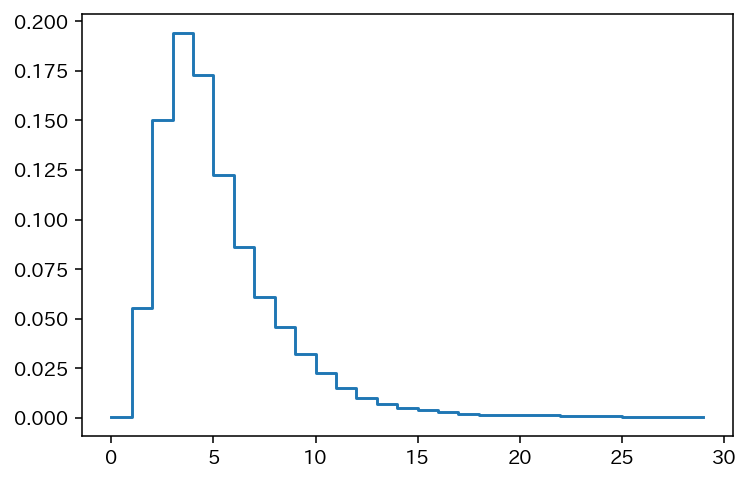

In [14]:
!pip install japanize-matplotlib nptyping &>/dev/null && wait $PID # pyplot用日本語フォント，Numpy用型ヒント
from matplotlib import pylab as plt
import japanize_matplotlib

import numpy as np
import pandas as pd

from pprint import pprint as pprint
from typing import Callable, List, Dict, Tuple, Any
from nptyping import NDArray, Float

# 発症〜公表タイムラグ
def loadDiffDate():
    df0 = pd.read_csv('drive/MyDrive/Colab Notebooks/data/患者テーブル.csv')
    df = df0.sort_values('発症_年月日')
    df['発症_年月日']=pd.to_datetime(df['発症_年月日'], format='%Y/%m/%d')
    df['公表_年月日']=pd.to_datetime(df['公表_年月日'], format='%Y/%m/%d')
    df['diff']=df['公表_年月日']-df['発症_年月日']
    df['diff']=df['diff'].dt.days

    hist, _=np.histogram(df['diff'].values, bins=30, range=(0,30), density=None)
    return hist/np.sum(hist)

def loadDiffDateTes():
    tmphist=loadDiffDate()
    plt.step(range(0,len(tmphist)),tmphist,where='post')
loadDiffDateTes()

def floor2(v):
    import math
    n=2  # 小数点以下n位
    return math.floor(v * 10 ** n) / (10 ** n)

def floor2str(v):
    return str(floor2(v))

sum= 0.9870468781408267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


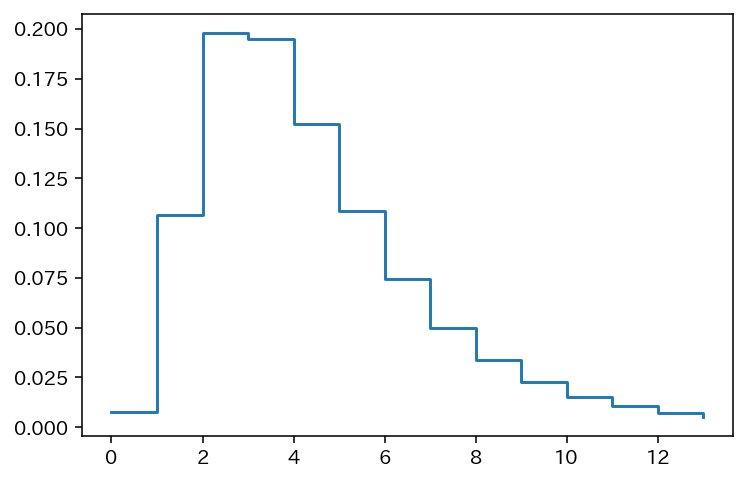

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


sum= 0.9782103393451957


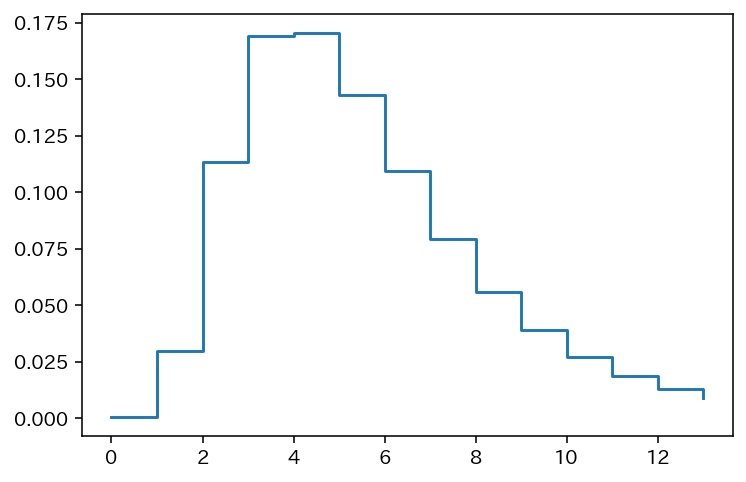

In [15]:
# serial intaval(世代時間)
# incubation period(潜伏期間)

import scipy.special as sps
# 世代時間の確率分布
def serial_int(xstart=0,xend=14,xstep=1)->Tuple[range,NDArray[Float]]:
    #https://github.com/aakhmetz/COVID19SerialInterval
    #"Lognormal distribution as the best-fit model for certain and probable pairs with right truncation"
    param1=1.376
    param2=0.567
    x=np.arange(xstart,xend,xstep)
    lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*sps.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
    y=[np.sum(lognormcdf(xx+xstep,param1,param2)-lognormcdf(xx,param1,param2)) for xx in x]

    #plt.step(x,y,where='post')
    #plt.show()
    return x,y

def serial_int_test():
    ts,pdf=serial_int()
    sum=np.sum(pdf)
    print("sum=",sum)
    plt.step(ts,pdf,where='post')
    plt.show()
    #pprint(pdf)

serial_int_test()

def incubation_period(xstart=0,xend=14,xstep=1):
    #https://bmjopen.bmj.com/content/10/8/e039652#DC1
    #mu=1.63 and sigma=0.50
    param1=1.63
    param2=0.50
    x=np.arange(xstart,xend,xstep)
    lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*sps.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
    y=[np.sum(lognormcdf(xx+xstep,param1,param2)-lognormcdf(xx,param1,param2)) for xx in x]

    #plt.step(x,y,where='post')
    #plt.show()
    return x,y

def incubation_period_test():
    ts,pdf=incubation_period()
    sum=np.sum(pdf)
    print("sum=",sum)
    plt.step(ts,pdf,where='post')
    plt.show()
    #pprint(pdf)

incubation_period_test()


In [23]:
GROUPS=["Area A","Area B"]
VARIANTS=["株未詳"]
Matrix=NDArray[(len(GROUPS),len(VARIANTS)),Float[64]]

class PopulationVariable:
    def __init__(self, name, init_values: Matrix,
                target_and_output_funcs: Dict[Any,List[Callable[[Any],Matrix]]]=None,
                init_d_values: Matrix=None,
                data_container=None) -> None:
                
        self.name=name
        self.values=[init_values.astype(np.float64)]
        self.target_and_output_funcs=target_and_output_funcs
        self.data_container=data_container
        if(init_d_values is not None):
            self.d=[init_d_values.astype(np.float64)]
        else:
            self.d=[np.zeros_like(init_values, dtype=np.float64)]
        self.input=[np.zeros_like(init_values, dtype=np.float64)]
        self.out=[np.zeros_like(init_values, dtype=np.float64)]
        self.correction=[np.zeros_like(init_values, dtype=np.float64)]

        self.values.insert(1,np.copy(self.values[0]))
        self.d.insert(1,np.zeros_like(self.d[0]))
        self.out.insert(1,np.zeros_like(self.out[0]))
        self.input.insert(1,np.zeros_like(self.input[0]))
        self.correction.insert(1,np.zeros_like(self.correction[0]))


    # 入力を受け入れて，values[t]に足す
    def add_inflow(self, t, value: Matrix)->None:
        #print(self.name+".add_inflow",t,np.sum(value))
        value=value.astype(np.float64)
        self.values[t]+=value
        self.d[t]+=value
        self.input[t]+=value
    
    # valuesとdの先頭を追加する．
    # あらかじめtarget_and_output_funcsに登録されている各targetごとの
    # 1) 出力関数fを呼び，targetごとの流出量を計算
    # 2) target.add_inflow()で出力する
    # 3) 流出量合計をself.valuesとself.dから引く
    def flush(self, t):
        if(self.target_and_output_funcs is not None):
            o={}
            for target, f in self.target_and_output_funcs.items():
                o[target]=f(self, self.data_container, self.values[t-1], t)
                
                target.add_inflow(t, o[target])
                self.values[t]-=o[target]
                self.out[t]+=o[target]
                self.d[t]-=o[target]

            # 負の値が出たときに補正する(その年齢層のみ)
            is_negative=(self.values[t]<=0)
            is_zero=(np.array(self.values[t]==0) & np.array(self.d[t]==0))
            is_negative=is_negative & (~is_zero)
            if(np.any(is_negative)):
                self.correction[t]=np.copy(self.values[t])
                self.d[t][is_negative]=-self.values[t][is_negative]
                self.values[t][is_negative]=0.0
                self.correction[t]=self.correction[t]-self.values[t]

                for target, f in self.target_and_output_funcs.items():
                    if(np.sum([vs for vs in o.values()])!=0):
                        target.add_inflow(t, self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()]))
                    else:
                        target.add_inflow(t, self.correction[t])
        # init
        if(t+1<len(self.values)):
            self.values[t+1]=np.copy(self.values[t])
            self.d[t+1]=np.zeros_like(self.d[t])
            self.out[t+1]=np.zeros_like(self.d[t])
            self.input[t+1]=np.zeros_like(self.d[t])
            self.correction[t+1]=np.zeros_like(self.values[t])
        else:
            self.values.insert(t+1,np.copy(self.values[t]))
            self.d.insert(t+1,np.zeros_like(self.d[t]))
            self.out.insert(t+1,np.zeros_like(self.d[t]))
            self.input.insert(t+1,np.zeros_like(self.d[t]))
            self.correction.insert(t+1,np.zeros_like(self.values[t]))

class FlowModel:
    vars=[]
    #def __init__(self) -> None:

    def add(self, pvar: PopulationVariable)->None:
        self.vars.append(pvar)

In [24]:
class DataContainer:
    def __init__(self,label=None,dV0=None,R0=None,E0=None):
        self.label=label
        self.NUM_OF_DAYS=170
        self.NUM_OF_CALCULATED_DAYS=0
        
        if(R0 is not None):
            self.R0=R0
        else:
            self.R0=1.2
        print("R0=",self.R0)

        self.N:Matrix=np.array([[1000],[100000]])

        #ゼロベクトル
        self.ZERO=np.zeros_like(self.N, dtype=np.float64)
        #1ベクトル
        self.ONE=np.ones_like(self.N, dtype=np.float64)

        self.I0:Matrix=np.array([
                    [100.0], # A
                    [0.0], # B
                    ])#隔離されてない発症者

        self.Q0:Matrix=np.array([
                    [4500.], # A
                    [0.], # B
                    ]) #療養者

        # かかりやすさ
        self.ALPHA=self.ONE
        
        #治癒率(I→R，Q→R)
        self.GAMMA=self.ALPHA*(1-0.1**(1/50))# #(1-GAMMA)^10=0.2 ⇒ GAMMA=1-0.2^(1/10)．順調な8割は10日目までに排菌が止まり，1割はCに残留する

        #隔離率 I→Q
        self.EPSILON=self.ZERO+0.151657 #I*(1-EPSILON)^10=0.1*I #完治までに10%が隔離されない
        #self.EPSILON=self.ZERO+1/10 #平均10日で発見・隔離される
        #self.EPSILON=self.ZERO+1/1000

        #発症率 E→I
        #self.DELTA=self.ZERO+(1/5.6)
        _,self.DELTA=serial_int()
        
        #重症化率
        self.KAPPA=self.ONE*0.06617624
        #ちなみに大阪5/23-以降の全年齢の重症化率K(t)=dC(t)/I(t-1)=0.06617624
        #重症化しない率(1-p)から: (1-p)/p=5.6, 重症化率p=0.151515

        #重症化後退院率．
        #self.LAMBDA=np.copy(self.ZERO)+(1-0.5**(1/14)) #(1-LAMBDA)^14=0.1 ⇒ LAMBDA=1-0.5^(1/14) 14日で1/10になる
        self.LAMBDA=1/self.KAPPA
        self.LAMBDA=self.KAPPA/np.sum(self.KAPPA)*(1-0.0001**(1/14))

        #感染率(R0=β/γ⇒β=R0γ．Iの減少要因の平均をγの代わりに利用する)
        self.BETA=10*self.R0*self.GAMMA/self.N #BETA=R0*GAMMA/N (R0の定義より．αは年齢別の係数)

        # Nに対するワクチン接種割合(速度)[-/day]．Nと同じ形の行列np.array()で年齢別に設定．
        self.OMEGA=np.array([
                    [1.], # A
                    [1.], # B
                    ])
        self.OMEGA_N=self.OMEGA*self.N #Nの割合
        if(0<np.sum(self.OMEGA)):
            self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
        self.OMEGA=self.OMEGA*((0.37/100)*np.sum(self.N)) #%/day
        #self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day
        #print("self.OMEGA init=",self.OMEGA)
        
        if(dV0 is not None):
            self.OMEGA=dV0
            #print("dV0 is not None: dV0=",dV0)
        self.dV=[np.copy(self.OMEGA)]

        # A-B間の感染(最初は不通)
        self.Tr=np.array([
                [1.,0.],
                [0.,1.],
                ])

        def StoV(self, d: DataContainer, s: Matrix, t)->Matrix:
            return d.ZERO

        def StoE(S, d: DataContainer, s: Matrix, t)->Matrix:
            print(t, "判定: (d.I.values[t-1]/d.N)[0]=",(d.I.values[t-1]/d.N)[0]," : ",0.3<(d.I.values[t-1]/d.N)[0])
            if(0.3<(d.I.values[t-1][0]/d.N[0])):
                print(t, "A-B間の伝染")
                # A-B間の感染
                self.Tr=np.array([
                        [0.5,0.5],
                        [0.5,0.5],
                        ])
            return d.BETA*d.Tr@d.I.values[t-1]*s

        def EtoI(E, d: DataContainer, e: Matrix, t)->Matrix:
            p=d.ZERO
            for s,delta in enumerate(d.DELTA):# ウィンドウ内の時間s=0〜len(DELTA)
                if(0<=t-s):
                    p+=1.5*delta*E.values[t-s]# psitives[t]=pdf[s]*E[t-s]
            return p

        def ItoR(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.GAMMA*i
        
        def ItoC(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.KAPPA*i

        def ItoQ(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.EPSILON*i
        
        def CtoR(I, d: DataContainer, c: Matrix, t)->Matrix:
            return d.LAMBDA*c

        def QtoC(Q, d: DataContainer, q: Matrix, t)->Matrix:
            return d.KAPPA*q

        def QtoR(Q, d: DataContainer, q: Matrix, t)->Matrix:
            return d.GAMMA*q

        self.fmodel=FlowModel()
        self.V=PopulationVariable('V',np.copy(self.ZERO), {}, init_d_values=self.dV[0]) #→出口なし
        self.R=PopulationVariable('R',np.copy(self.ZERO), {}) #→出口なし
        self.C=PopulationVariable('C',np.copy(self.ZERO),
                                  {self.R:CtoR},data_container=self) #critical(severe)
        self.Q=PopulationVariable('Q',np.copy(self.Q0),
                                  {self.C:QtoC, self. R:QtoR}, data_container=self) #quarantined
        self.I=PopulationVariable('I',self.I0,
                                  {self.R:ItoR, self.C:ItoC, self.Q:ItoQ},data_container=self)
        if(E0 is not None):
            self.E=PopulationVariable('E',E0*self.ALPHA,
                                    target_and_output_funcs={self.I:EtoI},data_container=self)
        else:
            self.E=PopulationVariable('E',np.copy(self.ZERO),
                                      target_and_output_funcs={self.I:EtoI},data_container=self)
            self.E0=self.E.values[0]
        self.S=PopulationVariable('S',np.copy(self.N),
                                {self.E:StoE, self.V:StoV},data_container=self)

        self.pipeline=[self.S,self.E,self.I,self.Q,self.C,self.R,self.V]
        self.before=[self.S,]
        self.patient=[self.E,self.I,self.Q,self.C]
        self.after=[self.R,self.V]
        
        print("label",self.label)

    def calc(self, T=None):
        if(T is None):
            #T=range(len(self.DELTA),self.NUM_OF_DAYS)
            T=range(self.NUM_OF_DAYS)
        
        for t in T:
            for pvar in self.pipeline:
                pvar.flush(t)

            self.NUM_OF_CALCULATED_DAYS=t
        return self


In [25]:
def run():
    datas=[
           DataContainer(label="接種なし",R0=1.7, dV0=np.array([[0],[0]]))
    ]
    for i, d in enumerate(datas):
        datas[i]=d.calc()
    return datas
datas=run()

R0= 1.7
label 接種なし
0 判定: (d.I.values[t-1]/d.N)[0]= [0.1]  :  [False]
1 判定: (d.I.values[t-1]/d.N)[0]= [0.07459003]  :  [False]
2 判定: (d.I.values[t-1]/d.N)[0]= [0.06942143]  :  [False]
3 判定: (d.I.values[t-1]/d.N)[0]= [0.10813399]  :  [False]
4 判定: (d.I.values[t-1]/d.N)[0]= [0.21107319]  :  [False]
5 判定: (d.I.values[t-1]/d.N)[0]= [0.30502436]  :  [ True]
5 A-B間の伝染
6 判定: (d.I.values[t-1]/d.N)[0]= [0.27658158]  :  [False]
7 判定: (d.I.values[t-1]/d.N)[0]= [0.1788649]  :  [False]
8 判定: (d.I.values[t-1]/d.N)[0]= [0.07129286]  :  [False]
9 判定: (d.I.values[t-1]/d.N)[0]= [0.00331803]  :  [False]
10 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
11 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
12 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
13 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
14 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
15 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
16 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
17 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
18 判定: (d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
48 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
49 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
50 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
51 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
52 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
53 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
54 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
55 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
56 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
57 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
58 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
59 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
60 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
61 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
62 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
63 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
64 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
65 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
66 判定: (d.I.values[t-1]/d.N)[0]= [0.]  :  [False]
67 

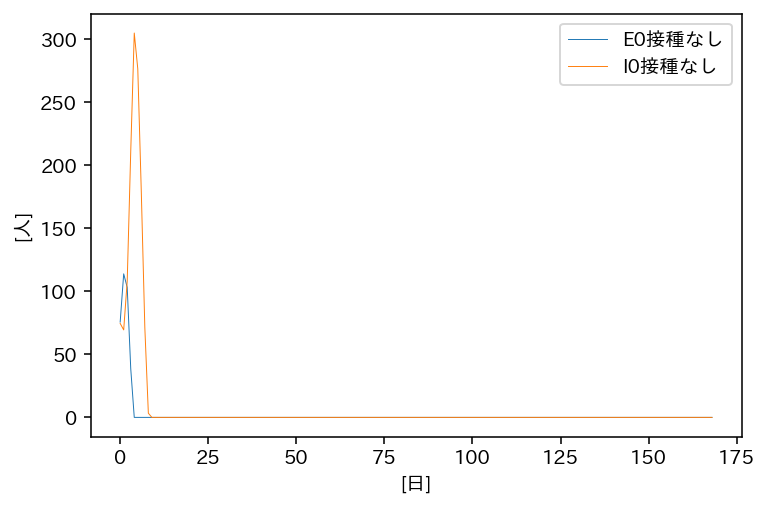

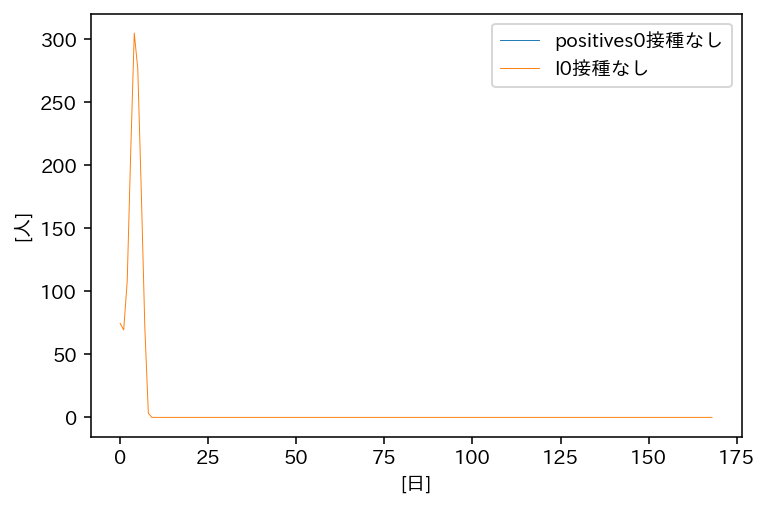

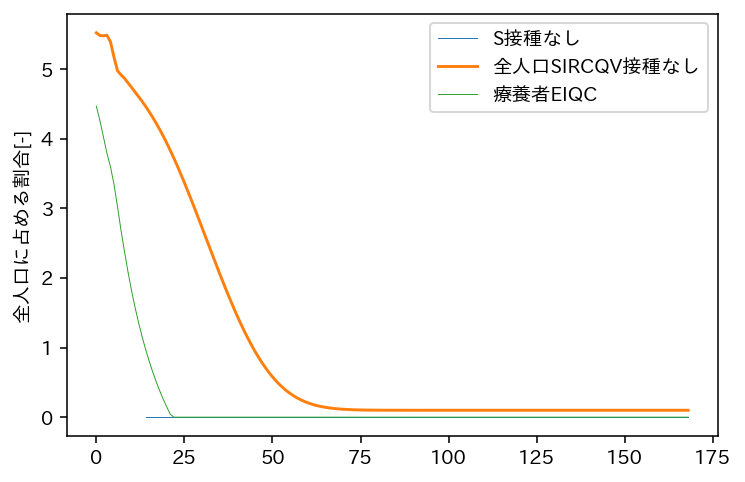

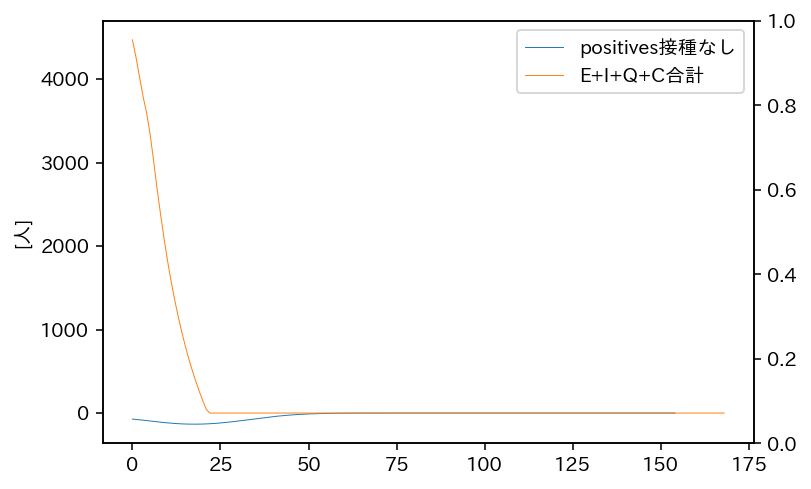

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


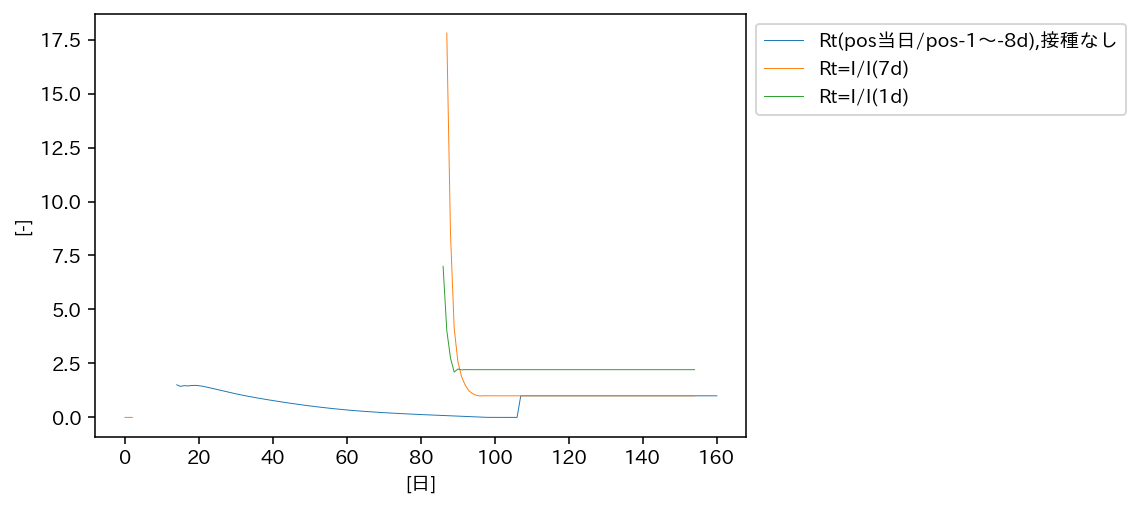

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in double_scalars


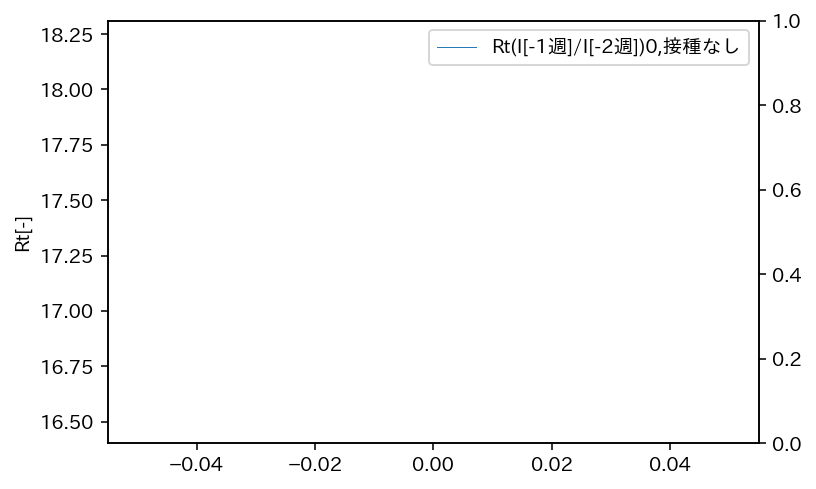

In [54]:
# two data plot
def plotdiff(datas):
    plt.rcParams["figure.dpi"]=140
    class Localdata:
        pass
    ds=[]
    NUM_OF_CALCULATED_DAYS=datas[0].NUM_OF_CALCULATED_DAYS
    NUM_OF_DAYS=datas[0].NUM_OF_DAYS

    for i in range(0,1):
        d=datas[0]
        ds.append(Localdata())
        ds[i].S=[]
        ds[i].E=[]
        ds[i].I=[]
        ds[i].R=[]
        ds[i].Q=[]
        ds[i].C=[]
        ds[i].V=[]
        ds[i].positives=[]
        ds[i].dV=[]
        ds[i].dI=[]
        ds[i].dC=[]
        for t in range(0,NUM_OF_CALCULATED_DAYS):
            
            ds[i].S.insert(t+1,d.S.values[t][i])
            ds[i].E.insert(t+1,d.E.values[t][i])
            ds[i].I.insert(t+1,d.I.values[t][i])
            ds[i].R.insert(t+1,d.R.values[t][i])
            ds[i].Q.insert(t+1,d.Q.values[t][i])
            ds[i].C.insert(t+1,d.C.values[t][i])
            ds[i].positives.insert(t+1,d.I.input[t][i])
            ds[i].dI.insert(t+1,d.I.d[t][i])
            ds[i].dC.insert(t+1,d.C.d[t][i])
        ds[i].label=d.label
        ds[i].N=d.N[i]
    T_14=range(14,len(ds[0].S))
    T=range(0,len(ds[0].S))
    '''
    print("",)
    print("",)
    print("",)
    print("",)
    print("",)
    print("",)
    (d.S[t]+d.I[t]+d.R[t]+d.C[t]+d.Q[t]
    '''
    for i, d in enumerate(ds):
        plt.plot(range(len(d.E)),d.E, label="E"+str(i)+d.label, linewidth=.5)
        plt.plot(range(len(d.I)),d.I, label="I"+str(i)+d.label, linewidth=.5)
        #plt.plot([np.sum(i) for i in d.Q], label="Q"+d.label, linewidth=.5)
        #plt.plot([np.sum(c) for c in d.C], label="Critical"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in T], label="E+I+Q+C合計,"+d.label, linewidth=.5)

        plt.plot(d.positives[t], label="positives"+str(i)+d.label, linewidth=.5)
        plt.plot(range(len(d.I)),d.I, label="I"+str(i)+d.label, linewidth=.5)
        #plt.plot([d.E[t][k]+d.I[t][k]+d.Q[t][k]+d.C[t][k] for t in T], label="E+I+Q+C合計,"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot(range(14,len(d.S)),[np.sum(s) for s in d.S[14:]]/sum(d.N), label="S"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.I], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.C[t])+sum(d.I[t]) for t in T], label="I+C"+d.label, linewidth=.5)
        plt.plot([np.sum((d.S[t]+d.I[t]+d.R[t]+d.C[t]+d.Q[t])/d.N) for t in range(len(d.S))], label="全人口SIRCQV"+d.label)
        plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in range(len(d.E))]/d.N, label="療養者EIQC", linewidth=.5)

    plt.ylabel("全人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    for i, d in enumerate(ds):
        ax1.plot([np.sum(m) for m in d.positives[14:]], label="positives"+d.label, linewidth=.5)
        #plt.plot([np.sum(m) for m in d.C], label="Critical"+d.label, linewidth=.5)
        ax1.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in range(len(d.E))], label="E+I+Q+C合計", linewidth=.5)
    plt.xlabel("[日]")
    ax1.set_ylabel("[人]")
    hand1, label1 = ax1.get_legend_handles_labels()
    hand2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(hand1 + hand2, label1 + label2,bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t])/np.sum(d.I[t-1]*d.S[t-1]/d.N) for t in range(1,NUM_OF_CALCULATED_DAYS)], label="Rt(pos当日/pos-1〜-8d),"+d.label, linewidth=.5)
        plt.plot(range(14,len(d.positives)-8),[np.sum(d.positives[t:t+7])/np.sum(d.positives[t-8:t-1]) for t in range(14,len(d.positives)-8)], label="Rt(pos当日/pos-1〜-8d),"+d.label, linewidth=.5)
        plt.plot([np.sum(d.I[t])/np.sum(d.I[t-8:t-1])*7 for t in range(14,len(d.I))], label="Rt=I/I(7d)", linewidth=.5)
        plt.plot([np.sum(d.positives[t])/np.sum(d.I[t-1])*7 for t in range(14,len(d.I))], label="Rt=I/I(1d)", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        ax1.plot([np.sum(d.I[0:t-13])/np.sum(d.I[t-14:t-22]) for t in range(21,len(d.I))], label="Rt(I[-1週]/I[-2週])"+str(i)+","+d.label, linewidth=.5)

    plt.xlabel("[日]")
    ax1.set_ylabel("Rt[-]")
    hand1, label1 = ax1.get_legend_handles_labels()
    hand2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(hand1 + hand2, label1 + label2,bbox_to_anchor=(1,1))
    plt.show()

plotdiff(datas)
